# Jukebox: Textures

In this notebook we do an initial exploration of the layers.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import jukebox
import torch
import librosa
import os
import numpy as np
import nussl
import matplotlib.pyplot as plt

from IPython.display import Audio
from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache
rank, local_rank, device = setup_dist_from_mpi()

/bin/sh: 1: sox: not found
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


Using cuda True


In [2]:
model = "5b" # or "1b_lyrics"     
vqvae, *priors = MODELS[model]
hparams = setup_hparams(vqvae, dict(sample_length = 1048576))
vqvae = make_vqvae(hparams, device)
vqvae = vqvae.eval()


Running  wget -O /home/pajouheshgar/.cache/jukebox/models/5b/vqvae.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar


--2022-05-10 09:46:38--  https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.60, 13.107.213.60, 2620:1ec:bdf::60, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7726329 (7.4M) [application/x-tar]
Saving to: ‘/home/pajouheshgar/.cache/jukebox/models/5b/vqvae.pth.tar’

     0K .......... .......... .......... .......... ..........  0% 14.3M 1s
    50K .......... .......... .......... .......... ..........  1% 14.8M 1s
   100K .......... .......... .......... .......... ..........  1%  472K 6s
   150K .......... .......... .......... .......... ..........  2%  405M 4s
   200K .......... .......... .......... .......... ..........  3% 16.4M 3s
   250K .......... .......... .......... .......... ..........  3%  353K 6s
   300K .......... .......... .......... .......... ..........  4%

Restored from /home/pajouheshgar/.cache/jukebox/models/5b/vqvae.pth.tar
0: Loading vqvae in eval mode


In [212]:
model_layers[:10]

['level_blocks-0-model-0-0',
 'level_blocks-0-model-0-1-model-0-model-0',
 'level_blocks-0-model-0-1-model-0-model-1',
 'level_blocks-0-model-0-1-model-0-model-2',
 'level_blocks-0-model-0-1-model-0-model-3',
 'level_blocks-0-model-0-1-model-0-model',
 'level_blocks-0-model-0-1-model-0',
 'level_blocks-0-model-0-1-model-1-model-0',
 'level_blocks-0-model-0-1-model-1-model-1',
 'level_blocks-0-model-0-1-model-1-model-2']

Num channels = 32


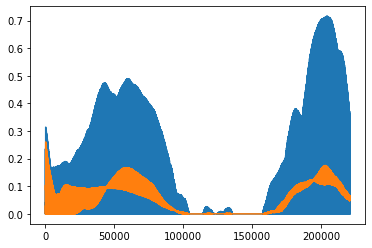

22050


ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpost

In [236]:
import scipy
from lucent.optvis.render import hook_model
from lucent.modelzoo.util import get_model_layers
import matplotlib.pyplot as plt

t = np.linspace(0, 10, sample_rate * 10)
f_start = 100
f_end = 4000
num_seconds = 10
sample_rate = 44100
freqs = np.linspace(f_start, f_end, num_seconds * sample_rate)

t = np.linspace(0, num_seconds, sample_rate * num_seconds)
wave = scipy.signal.chirp(t, f_start, num_seconds, f_end) # Frequency sweep

encoder = vqvae.encoders[2].eval()
model_layers = get_model_layers(encoder)
hook = hook_model(encoder, None)

with torch.no_grad():
        wave = torch.from_numpy(wave).cuda().float()
        wave = wave[None, None, :]
        xs = encoder(wave)

layer_name = 'level_blocks-0-model-0-0'
layer_name = 'level_blocks-0-model-0-1-model-3-model-0'
# layer_name = 'level_blocks-2-model-2'
activations = hook(layer_name)
b, c, n = activations.shape

print(f"Num channels = {c}")
channel_idx = 7
channel_activation = activations[0, channel_idx, :]
channel_activation = channel_activation.detach().cpu().numpy()


smooth_channel_activation = np.convolve(channel_activation, np.ones(25)/25, mode='valid')

plt.plot(channel_activation)
plt.plot(smooth_channel_activation)

# plt.plot(freqs)
plt.show()

channel_activation = (channel_activation - channel_activation.min())
channel_activation = channel_activation / channel_activation.max()
channel_activation = channel_activation * 2 - 1

channel_sample_rate = int(n / num_seconds)
print(channel_sample_rate)
signal = nussl.AudioSignal(audio_data_array=channel_activation, sample_rate=channel_sample_rate)
signal.embed_audio()

In [151]:
from lucent.optvis.param.color import to_valid_rgb, to_waveform
from lucent.optvis import render, param, transform, objectives
from lucent.optvis.transform import jitter_audio
import torchaudio



def multiple_harmonic_series_audio(n_seconds, sample_rate, n_ff=1, n_harmonics=10):
    ff = np.random.rand(n_ff).astype(np.float32) * np.pi / 10  # [0, pi]
    ff = torch.from_numpy(ff).cuda()
    ff = ff.detach().clone().requires_grad_(True)
    harmonic_strength = torch.tensor([[0.6 ** i for i in range(n_harmonics)] 
                                      for j in range(n_ff)]).cuda()
    harmonic_strength = harmonic_strength.detach().clone().requires_grad_(True)
    
    
    t = torch.linspace(0, n_seconds, int(sample_rate * n_seconds)).cuda()
    t = t.detach().clone().requires_grad_(False)
    
    # print(harmonic_strength.shape, ff.shape)
    def inner():
        
        wave = 0
        alpha = harmonic_strength / torch.sum(harmonic_strength, dim=1, keepdim=True)
        for j in range(len(ff)):
            for i in range(n_harmonics):
                freq = ff[j] * (i + 1) * sample_rate / (2 * np.pi) # [0, s/2]
                freq = torch.clip(freq, 0, sample_rate / 2)

                if torch.abs(freq) > sample_rate / 2:
                    a = 0.0
                else:
                    a = alpha[j, i]
                wave += torch.sin(2 * np.pi * freq * t) * a

        wave = torch.tanh(wave)[None, None, :]
        # print(wave.shape)
        
        return wave
    
    return [ff, harmonic_strength], inner

seed = 41
n_seconds = 1.0
sample_rate = 44100
n_harmonics = 5
num_f = 1
torch.manual_seed(seed)
np.random.seed(seed)
# param_f = lambda: harmonic_series_audio(n_seconds, sample_rate, n_harmonics)
param_f = lambda: multiple_harmonic_series_audio(n_seconds, sample_rate, num_f, n_harmonics)

optimizer = lambda params: torch.optim.Adam(params, lr=1e-2)

kwargs = {}
kwargs['optimizer'] = optimizer
kwargs['param_f'] = param_f
kwargs['transforms'] = [lambda x: x]
kwargs['verbose'] = 0
# kwargs['batch'] = batch_size
kwargs['thresholds'] = (16, 32, 64)


kwargs['objective_f'] = "level_blocks_1_model_2:5"
# kwargs['objective_f'] = "level_blocks_2_model_2:0"

# kwargs['objective_f'] = objectives.neuron_1D("level_blocks_2_model_0_1_model_2", 30)

with torch.autograd.set_detect_anomaly(True):
    result = render.render_audio(vqvae.encoders[2], **kwargs)
    
audio_out = result['audios']
grad_out = result['grads']


print("Fundamentals before optimization")
torch.manual_seed(seed)
np.random.seed(seed)
params, audio_f = param_f()
print(params[0] * sample_rate / (2 * np.pi))

print("Fundamentals after optimization")
print(result['params'][0] * sample_rate / (2 * np.pi))


signal = nussl.AudioSignal(audio_data_array=audio_out[-1][0,:,0], sample_rate=sample_rate)
signal.embed_audio()


100%|██████████| 64/64 [00:41<00:00,  1.55it/s, loss=0.055803895] 


Fundamentals before optimization
tensor([553.2866], device='cuda:0', grad_fn=<DivBackward0>)
Fundamentals after optimization
tensor([-404.8814], device='cuda:0', grad_fn=<DivBackward0>)


ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpost

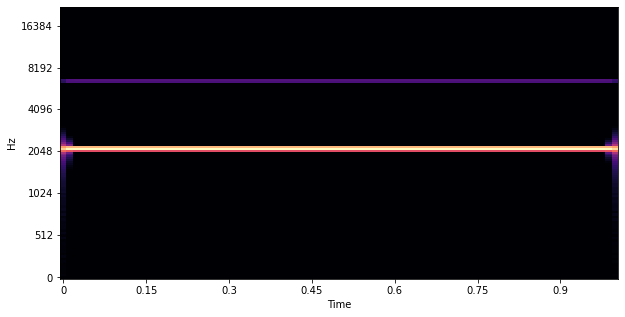

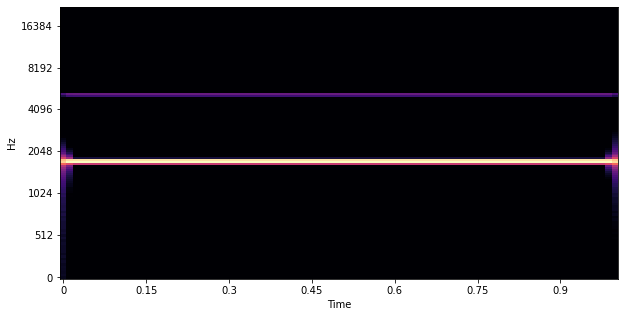

In [144]:
torch.manual_seed(seed)
np.random.seed(seed)
params, audio_f = param_f()
wave = audio_f().detach().cpu().numpy()


x1 = audio_out[-1][0, :, 0]


signal1 = nussl.AudioSignal(audio_data_array=x1, sample_rate=sample_rate)


signal2 = nussl.AudioSignal(audio_data_array=wave[0, 0], sample_rate=sample_rate)


plt.figure(figsize=(10, 5))
# nussl.utils.visualize_spectrogram(signal1)
nussl.utils.visualize_spectrogram(signal1, y_axis='mel')


plt.figure(figsize=(10, 5))
# nussl.utils.visualize_spectrogram(signal2)
nussl.utils.visualize_spectrogram(signal2, y_axis='mel')


plt.show()


[0.         0.2481671  0.45450577 0.60134155 0.69352865]


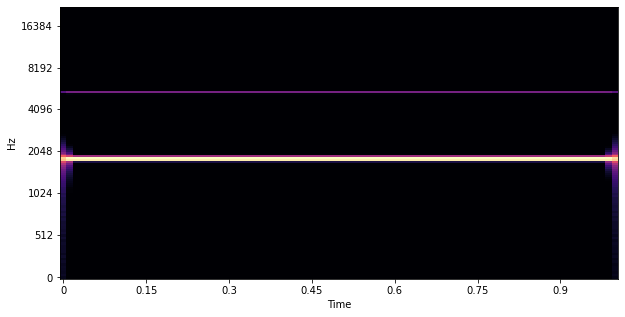

[0.         0.25400406 0.46334177 0.61005795 0.70026493]


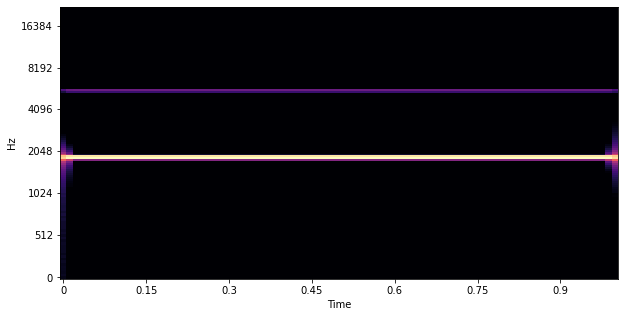

[0.         0.2584786  0.47003856 0.6165582  0.70517045]


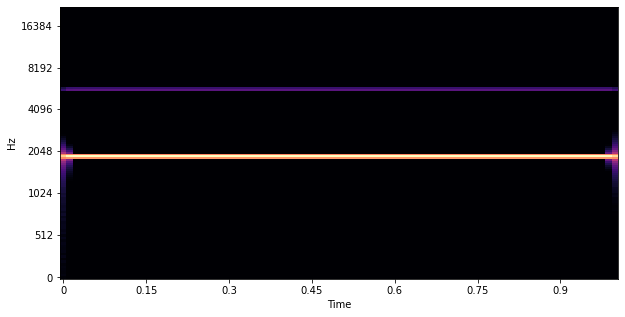

[0.         0.2926079  0.5188727  0.66106987 0.73554707]


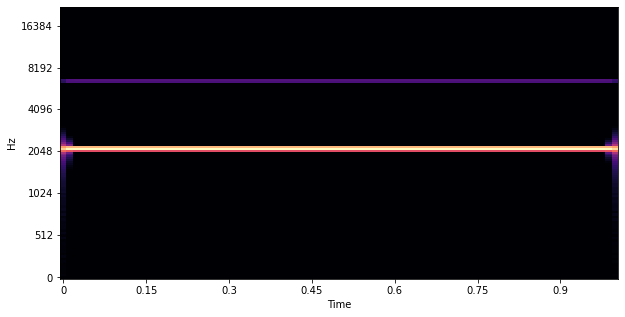

In [145]:
# torch.manual_seed(seed)
# np.random.seed(seed)
# params, audio_f = param_f()
# wave = audio_f().detach().cpu().numpy()

for i in range(len(audio_out)):

    x1 = audio_out[i][0, :, 0]

    print(x1[:5])

    signal1 = nussl.AudioSignal(audio_data_array=x1, sample_rate=sample_rate)
    plt.figure(figsize=(10, 5))
    # nussl.utils.visualize_spectrogram(signal1)
    nussl.utils.visualize_spectrogram(signal1, y_axis='mel')

    plt.show()
